# Atividade Somativa de Processamento de Linguagem Natural

-------------------------------------------------------
## Pontifícia Universidade Católica do Paraná
## Curso de BigData e Inteligência analítica
## Estevan Rafael Tomazini                 
## Professor Tutor Lucas Emanuel Silva e Oliveira
--------------------------------------------------------



# Para economizar no espaço, decidi não utilizar o notebook montado para a apresentação da atividade Somatória e trazer apenas as modificações:

### Como lembrete, as atividades propostas são:

## Atividade Somativa 2 - Como podemos tentar melhorar os resultados?
### 1) Redução da granularidade dos sentimentos Como podemos ver na matriz de confusão o classificador tem vários pontos de erro, em todas emoções. E se modificarmos o corpus para ao invés de 7 emoções, trabalhar com as 3 clássicas (positivo, neutro, negativo)?

### 2) Configuração dos parâmetros de extração de atributos e do classificador Altere a configuração de pelo menos um atributo gerado pela vetorização das palavras (i.e., CountVectorizer) e também pelo classificador utilizado.

### 3) Adicione novas etapas de extração de atributos ou de pré-processamento Incorpore ao menos uma nova etapa de pré-processamento ou extração de atributos (e.g., TF-IDF) ao pipeline atual.

### 4) Utilize outro classificador de texto Treine ao menos um novo modelo utilizando um classificador de textos diferentes. Ele pode pertencer à biblbioteca sklearn ou qualquer outra.

In [41]:
## importações iniciais, sem contar aquelas que foram necessárias no decorrer do trabalho.

In [17]:
import nltk
from nltk import tokenize
from nltk.corpus import stopwords as stopwords_nltk  # Renomeie a variável das stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV



In [2]:
# Carregando arquivo de dados utilizado nesse trabalho
with open("analise-sentimentos-2000-noticias.txt", "r", encoding="utf-8-sig") as file:
    linhas = file.readlines()

# Dicionário modificado para proposta de modificação 1,  para mapear emoções para as novas classes
mapeamento_emocoes = {
    'alegria': 'positivo',
    'raiva': 'negativo',
    'medo': 'negativo',
    'desgosto': 'negativo',
    'tristeza': 'negativo',
    'neutro': 'neutro'
}



In [3]:
# Criando um novo arquivo com as classes reduzidas
with open("analise-sentimentos-3-classes.txt", "w", encoding="utf-8-sig") as novo_arquivo:
    for linha in linhas:
        emocao, texto = linha.strip().split(";;")
        nova_emocao = mapeamento_emocoes.get(emocao, None)
        if nova_emocao:
            novo_arquivo.write(f"{nova_emocao};;{texto}\n")



In [23]:
# Carregando novo arquivo com as classes reduzidas
with open("analise-sentimentos-3-classes.txt", "r", encoding="utf-8-sig") as file:
    data_3_classes = file.readlines()



In [8]:
import nltk
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

In [18]:
# Carregue as stopwords
stop_words_nltk = set(stopwords_nltk.words('portuguese'))  # Renomeando as variáveis

In [19]:
## e crie um stemmer
stemmer = RSLPStemmer()

In [20]:
# Função de pré-processamento
def meu_preprocessador(text):
    text = text.lower()
    words = tokenize.word_tokenize(text, language='portuguese')
    words_no_stopwords = [word for word in words if word not in stop_words_nltk]
    stemmed_words = [stemmer.stem(word=word) for word in words_no_stopwords]
    return ' '.join(stemmed_words)



In [25]:
# Carregar o arquivo de dados com as três classes
with open("analise-sentimentos-3-classes.txt", "r", encoding="utf-8-sig") as file:
    data_3_classes = file.readlines()

# Extrair os rótulos das novas classes a partir do arquivo
rotulos_3_classes = [linha.strip().split(";;")[0] for linha in data_3_classes]

In [26]:
# Divisão treino-teste
X_train, X_test, y_train, y_test = train_test_split(data_3_classes, rotulos_3_classes, test_size=0.10, random_state=42)



In [27]:
# Configure os hiperparâmetros a serem ajustados
parametros_grid = {
    'vect__max_features': [1000, 5000, 10000],
    'clf__C': [0.1, 1, 10],
}



In [29]:
from sklearn.pipeline import Pipeline

In [31]:
# 1º tentativa é o classificador SVM

clf = Pipeline([
    ('vect', TfidfVectorizer(preprocessor=meu_preprocessador)),
    ('clf', SVC(kernel='linear'))
])



In [33]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [34]:
# Realize uma busca em grade para encontrar os melhores hiperparâmetros
grid_search = GridSearchCV(clf, parametros_grid, cv=5)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(preprocessor=<function meu_preprocessador at 0x78d1da138dc0>)),
                                       ('clf', SVC(kernel='linear'))]),
             param_grid={'clf__C': [0.1, 1, 10],
                         'vect__max_features': [1000, 5000, 10000]})

In [35]:
# Exibição de hiperparametros mais adequados:
print("Melhores parâmetros:")
print(grid_search.best_params_)


Melhores parâmetros:
{'clf__C': 1, 'vect__max_features': 1000}


In [36]:
# Usa o modelo com os melhores parâmetros para fazer previsões
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)



In [37]:
# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy:.2f}')



Acurácia: 0.99


In [50]:
## Me pareceu overfit

In [38]:
report = classification_report(y_test, y_pred)
print('Relatório de Classificação:')
print(report)

Relatório de Classificação:
              precision    recall  f1-score   support

    negativo       1.00      0.99      1.00       110
      neutro       1.00      1.00      1.00        52
    positivo       0.93      1.00      0.96        13

    accuracy                           0.99       175
   macro avg       0.98      1.00      0.99       175
weighted avg       0.99      0.99      0.99       175



In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# mostrar a matriz confusão:

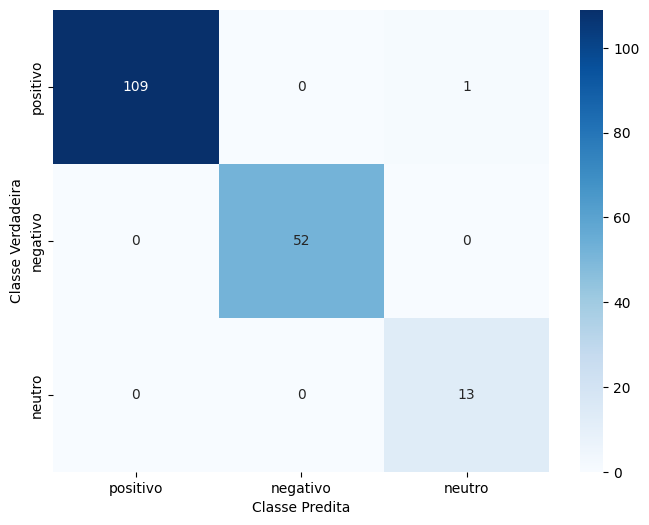

In [40]:
confusion = confusion_matrix(y_test, y_pred)
rotulos_nomes = ['positivo', 'negativo', 'neutro']


plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=rotulos_nomes, yticklabels=rotulos_nomes)

plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.show()

In [ ]:
## apenas um erro no neutro

# Testando outros modelos:

In [43]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [44]:
classifiers = [
    ('SVM', SVC(kernel='linear', C=1)),
    ('Naive Bayes', MultinomialNB()),
    ('Random Forest', RandomForestClassifier(n_estimators=100))
]

for name, classifier in classifiers:
    clf = Pipeline([
        ('vect', TfidfVectorizer(preprocessor=meu_preprocessador)),
        ('clf', classifier)
    ])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name}: Acurácia = {accuracy:.2f}')

SVM: Acurácia = 0.99
Naive Bayes: Acurácia = 0.79
Random Forest: Acurácia = 0.99


In [46]:
from sklearn.naive_bayes import MultinomialNB

# modelo Naive Bayes
nb_clf = Pipeline([
    ('vect', TfidfVectorizer(preprocessor=meu_preprocessador)),
    ('clf', MultinomialNB())
])
nb_clf.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 TfidfVectorizer(preprocessor=<function meu_preprocessador at 0x78d1da138dc0>)),
                ('clf', MultinomialNB())])

In [48]:
from sklearn.ensemble import RandomForestClassifier

# modelo Random Forest
rf_clf = Pipeline([
    ('vect', TfidfVectorizer(preprocessor=meu_preprocessador)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_clf.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 TfidfVectorizer(preprocessor=<function meu_preprocessador at 0x78d1da138dc0>)),
                ('clf', RandomForestClassifier(random_state=42))])

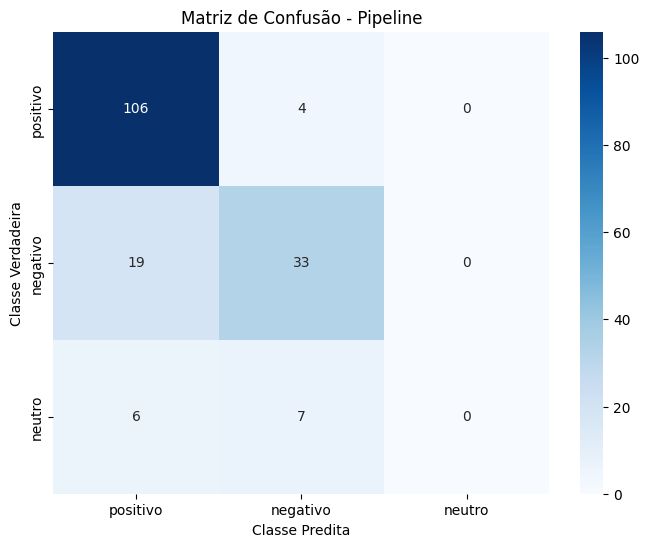

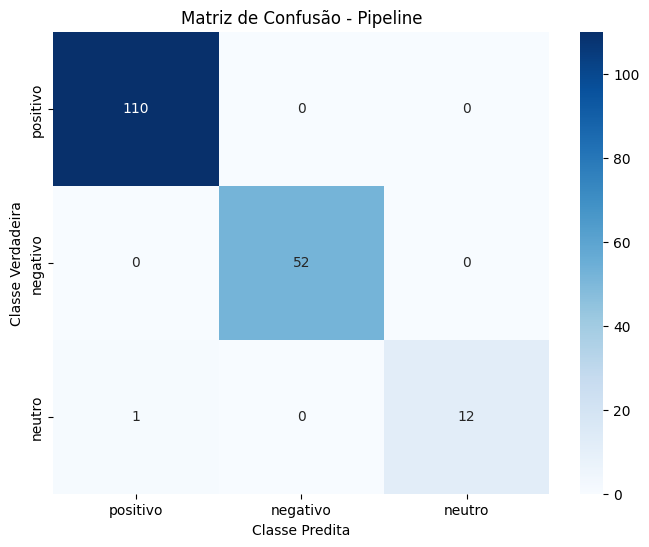

In [51]:
# Função matriz de confusão
def plot_confusion_matrix(model, X_test, y_test, class_names):
    y_pred = model.predict(X_test)
    confusion = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Classe Predita')
    plt.ylabel('Classe Verdadeira')
    plt.title(f'Matriz de Confusão - {model.__class__.__name__}')
    plt.show()

# Plotar o modelo Naive Bayes
plot_confusion_matrix(nb_clf, X_test, y_test, rotulos_nomes)

# Plotar o modelo Random Forest
plot_confusion_matrix(rf_clf, X_test, y_test, rotulos_nomes)

In [52]:
# O SVM e o random forest obtiveram apenas um erro positivo -> neutro cada, enquanto Naive-Bayes foi menos eficiente por 35 erros, sendo que não acertou nenhuma palavra "neutra".

# O que foi testado:

## 1 - Redução na granularidade dos sentimentos
### em positivo, negativo e neutro. No inicio do notebook - provavelmente foi positiva devido a diminuição da complexidade da análise.

## 2 - Classificador SVM e Configuração de hiperparametros   
### Utilizado o classificador TfId Vectorizerexperimentando diferentes valores de hiperparâmetros para o TfidfVectorizer e o classificador SVM, onde encontrou n= 1000.

## 3 - Adição de Novas Etapas de Extração de Atributos ou de Pré-processamento
### Compara TfidVectorizer com o Count vectorizer da aula.

## 4 - Utilização de Outros modelos para comparação (SVM/NB/RF)
### através do SVM, Naive bayes e Random forest. Onde o SVM e RF foram modelos com score de 0.99, que pode indicar overfitting, mas nesse caso apresentaram apenas 1 erro para uma palavra neutra. Naive-Bayes contou com 35 erros e errou todas as palavras neutras, se mostrando o menos eficiente para as condições desse experimento.





In [53]:
# última cálula é utilizada para conversão em HTML

In [ ]:
%%shell
jupyter nbconvert --to html /